In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#from gprofiler import GProfiler
#import loompy as lp
#import rpy2.rinterface_lib.callbacks
import logging
#import scrublet as scr
#from rpy2.robjects import pandas2ri
#import anndata2ri
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.0


In [5]:
import os              
os.environ['PYTHONHASHSEED'] = '0'
import desc
#import keras
import tensorflow as tf
from time import time                                                       
import sys

### Import dataset APE_pos e APE_neg

In [19]:
APE_pos = sc.read_10x_mtx("/home/spuccio/homeserver2/SP018_Pelosi/Lib_APE-POS/outs/filtered_feature_bc_matrix",var_names='gene_symbols',make_unique=True,)

In [69]:
APE_pos.obs['dataset'] = "APE_pos"

In [20]:
APE_neg = sc.read_10x_mtx("/home/spuccio/homeserver2/SP018_Pelosi/Lib_APE-NEG/outs/filtered_feature_bc_matrix",var_names='gene_symbols',make_unique=True,)

In [70]:
APE_neg.obs['dataset'] = "APE_neg"

In [71]:
adata = APE_pos.concatenate(APE_neg,index_unique='-')

### Quality control

In [72]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)

In [73]:
adata.shape

(7976, 15660)

In [74]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [75]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [76]:
adata.var['rb'] = adata.var_names.str.startswith('RP')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

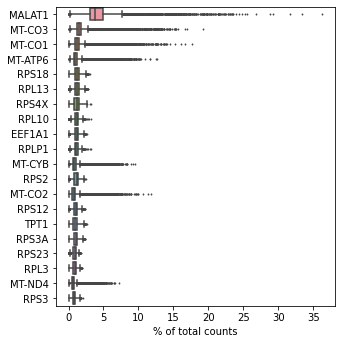

In [77]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [78]:
print("Cell x Genes before filtering")
print(adata.n_obs, adata.n_vars)

Cell x Genes before filtering
7976 15660


... storing 'dataset' as categorical
... storing 'feature_types' as categorical


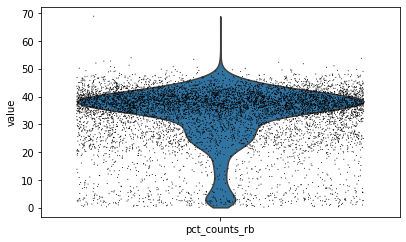

In [79]:
sc.pl.violin(adata, ['pct_counts_rb'],jitter=0.4)

In [80]:
adata = adata[adata.obs.pct_counts_rb < 45, :]
print("Cell x Genes after filtering cell with high ribosomial")
print(adata.n_obs, adata.n_vars)

Cell x Genes after filtering cell with high ribosomial
7657 15660


In [81]:
adata = adata[adata.obs.pct_counts_rb > 10, :]
print("Cell x Genes after filtering cell with high ribosomial")
print(adata.n_obs, adata.n_vars)

Cell x Genes after filtering cell with high ribosomial
7210 15660


In [82]:
#sc.pl.violin(adata, ['pct_counts_mt'],jitter=0.4)

In [83]:
adata = adata[adata.obs.pct_counts_mt < 10, :]
print("Cell x Genes after filtering cell with high mithocondrial")
print(adata.n_obs, adata.n_vars)

Cell x Genes after filtering cell with high mithocondrial
6720 15660


In [84]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["external_gene_name", "start_position", "end_position", "chromosome_name","gene_biotype"],).set_index("external_gene_name")

In [85]:
annot['gene_biotype'].unique()

array(['Mt_tRNA', 'Mt_rRNA', 'protein_coding', 'processed_pseudogene',
       'lncRNA', 'snRNA', 'unprocessed_pseudogene', 'misc_RNA',
       'transcribed_unprocessed_pseudogene',
       'transcribed_processed_pseudogene', 'TEC', 'rRNA',
       'IG_V_pseudogene', 'rRNA_pseudogene', 'miRNA',
       'transcribed_unitary_pseudogene', 'unitary_pseudogene', 'snoRNA',
       'scaRNA', 'polymorphic_pseudogene', 'pseudogene', 'ribozyme',
       'sRNA', 'TR_V_gene', 'TR_V_pseudogene', 'TR_D_gene', 'TR_J_gene',
       'TR_C_gene', 'TR_J_pseudogene', 'IG_C_gene', 'IG_C_pseudogene',
       'IG_J_gene', 'IG_J_pseudogene', 'IG_D_gene', 'IG_V_gene',
       'IG_pseudogene', 'translated_processed_pseudogene', 'scRNA',
       'vault_RNA', 'translated_unprocessed_pseudogene'], dtype=object)

In [86]:
pd.DataFrame(adata.var_names)

,0
0,AL669831.5
1,LINC00115
2,FAM41C
3,NOC2L
4,KLHL17
...,...
15655,AL592183.1
15656,AC007325.4
15657,AL354822.1
15658,AC004556.1


In [87]:
annot = pd.merge(pd.DataFrame(adata.var_names),annot,left_on=0,right_on="external_gene_name",how="left")

In [88]:
annot= annot.drop_duplicates([0])
annot = annot.fillna("Not_available")

In [89]:
adata.var['gene_biotype'] = annot.set_index(0)['gene_biotype']
protein_coding = annot[0].loc[annot['gene_biotype']=="protein_coding"].reset_index()
del protein_coding['index']
protein_gene_indicator = np.in1d(adata.var_names, protein_coding)
adata = adata[:, protein_gene_indicator]

Trying to set attribute `.var` of view, copying.


In [90]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)
adata = adata[:, ~mito_gene_indicator]

In [91]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('MALAT1')
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
remove = np.add(ribo_genes, malat1)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

6720 12998
6720 12901


In [92]:
adata.raw = adata

### Normalization

In [93]:
adata2 = adata.copy()
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)

In [95]:
adata2

AnnData object with n_obs × n_vars = 6720 × 12901
    obs: 'dataset', 'batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rb', 'gene_biotype'
    uns: 'log1p'

In [96]:
adata2=desc.scale_bygroup(adata2,"dataset")

In [97]:
save_dir="/home/spuccio/homeserver2/SP018_Pelosi/Temp"
adata2=desc.train(adata2,
        dims=[adata2.shape[1],64,32],
        tol=0.005,
        n_neighbors=10,
        batch_size=256,
        louvain_resolution=[0.4,0.5,0.6,0.7,0.8],# not necessarily a list, you can only set one value, like, louvain_resolution=1.0
        save_dir=str(save_dir),
        do_tsne=False,
        learning_rate=200, # the parameter of tsne
        use_GPU=False,
        num_Cores=30, #for reproducible, only use 1 cpu
        num_Cores_tsne=4,
        save_encoder_weights=False,
        save_encoder_step=3,# save_encoder_weights is False, this parameter is not used
        use_ae_weights=False,
        do_umap=True)

Start to process resolution= 0.4
The number of cpu in your computer is 32

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
use_ae_weights=False, the program will rerun autoencoder
Pretraining the 1th layer...
learning rate = 0.1
Train on 6720 samples
Epoch 1/50
6720/6720 [==============================] - 2s 251us/sample - loss: 0.7448
Epoch 2/50
6720/6720 [==============================] - 1s 82us/sample - loss: 0.7436
Epoch 3/50
6720/6720 [==============================] - 1s 81us/sample - loss: 0.7427
Epoch 4/50
6720/6720 [==============================] - 1s 78us/sample - loss: 0.7419
Epoch 5/50
6720/6720 [==============================] - 1s 77us/sample - loss: 0.7412
Epoch 6/50
6720/6720 [==============================] - 0s 71us/sample - loss: 0.7405
Epoch 7/50
6720/6720 [==============================] - 1s 77us/sample - loss: 0.7400
Epoch 8/50
6720/6720 [==============================] - 1s 80us/sample - loss: 0.7396
Epoch 9/50
6720/6720 [

In [98]:
adata2

AnnData object with n_obs × n_vars = 6720 × 12901
    obs: 'dataset', 'batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'n_counts', 'desc_0.4', 'desc_0.5', 'desc_0.6', 'desc_0.7', 'desc_0.8'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rb', 'gene_biotype'
    uns: 'log1p', 'umap', 'prob_matrix0.4', 'prob_matrix0.5', 'prob_matrix0.6', 'prob_matrix0.7', 'prob_matrix0.8'
    obsm: 'X_Embeded_z0.4', 'X_umap', 'X_umap0.4', 'X_Embeded_z0.5', 'X_umap0.5', 'X_Embeded_z0.6', 'X_umap0.6', 'X_Embeded_z0.7', 'X_umap0.7', 'X_Embeded_z0.8', 'X_umap0.8'
    obsp: 'distances', 'connectivities'

In [99]:
adata.write("/home/spuccio/homeserver2/SP018_Pelosi/Integration_APE_pos_APE_neg/Desc.h5ad")
adata2.write("/home/spuccio/homeserver2/SP018_Pelosi/Integration_APE_pos_APE_neg/No_Desc.h5ad")

... storing 'gene_biotype' as categorical
... storing 'gene_biotype' as categorical
... storing 'gene_biotype' as categorical
... storing 'gene_biotype' as categorical
